**Hollywood Actor Image Classification Model Project**

By: Anupam Sivaram

# Motivation for the Project

Outside of a few stellar original shows, Amazon Prime Video's streaming catalogue typically captures less of my attention than that of Netflix or HBO Max. However, one very cool feature unique to Prime is "X-Ray", a sidebar in the pause menu that gives viewers more details about the soundtrack, production, and most interestingly, the actors on screen in that moment. 

As someone hoping to break into the streaming market one day with my writing, I wanted to understand this feature more. By building a simple version of the "X-Ray" feature, I sought to understand how Prime return results about on-screen actors in realtime; how my simple model might be tuned and scaled; and assess why competitors like Netflix and HBO Max have not instituted something similar.

# Initial Hypothesis and Questions to Answer

My initial hypothesis is:

*   The Haar Cascade method within OpenCV2 will be sufficient to predict the identity of a Hollywood actor, given an image with a full visible face. 


I hope to answer the following questions by the end of this project:

1. Can this goal be achieved with the use of simple object detection methods like Haar Cascade, without more sophisticated methods like CNNs?
2. What factors may confuse the image classification model?
3. How can the model be made more accurate?
4. Outside of the data analysis, given that Prime's X-Ray feature is over 10 years old, why might competitors abstain from replicating the feature?

# Import Libraries

In [4]:
!pip install joblib
!pip install xgboost
import joblib
import json
print("Done.")

Done.


In [6]:
from IPython.utils import io

import numpy as np
import pywt
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sn

import os
import shutil

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

print("Done.")

Done.


# Import Raw Data and Test Detection Functions

In the real case of Prime, the streaming service holds copyright licenses for all of the shows that they host on their platform. For my data collection, I had a few options:

1.   Manually download images from Google Images. This would be bad for scalability. 
2.   Webscrape using Python. Google is famously averse to techniques like this and would most likely block efforts.
3. Use the [Fatkun Chrome extension](https://chrome.google.com/webstore/detail/fatkun-batch-download-ima/nnjjahlikiabnchcpehcpkdeckfgnohf/related?hl=en) to download sets of Google Images. 

I decided to go with Option 3. Because I do not hold the copyright to the images that I used in this analysis, I have abstained from uploading a dataset with the images; however, my data collection process is easily replicable by searching for "(actor name) headshot" and using the Fatkun extension to download several pictures of that actor. I have also included some of the images from that dataset in my analysis here, for the purpose of the analysis, but request that these images are not downloaded from the Notebook. 

I chose to look for images of Tom Cruise, Leonardo Dicaprio, Brad Pitt, Dwayne Johnson, and Will Smith. I chose these actors in particular because (1) choosing diverse genders in my data set would most likely give my prediction model an advantage that I did not want to give it, (2) I wanted to assess how my model did when confronted with the same or different races, and (3) these actors were all featured in big-budget 2023 movies.

In [7]:
# Pull a sample image from my local drive and assess dimensions.

img = cv2.imread('/Users/anupamsivaram/Desktop/Image Classification Code/Raw Test Images/brad pitt headshot - Google Search/brad-pitt-7.jpg')
img.shape

(300, 300, 3)

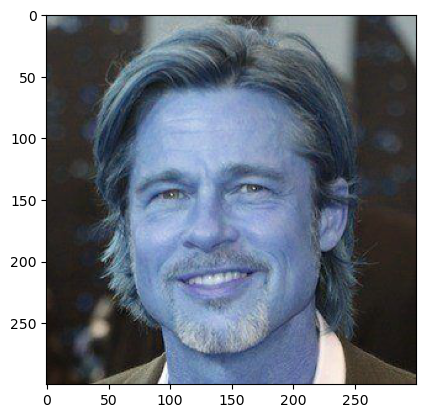

In [8]:
plt.imshow(img)

In [9]:
# Convert that image into grayscale.

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(300, 300)

In [10]:
gray

array([[143, 146, 148, ..., 169, 169, 169],
       [141, 148, 154, ..., 167, 167, 167],
       [145, 153, 159, ..., 167, 167, 167],
       ...,
       [ 23,  25,  27, ...,  77,  79,  77],
       [ 25,  26,  27, ...,  74,  76,  74],
       [ 26,  27,  28, ...,  72,  74,  72]], dtype=uint8)

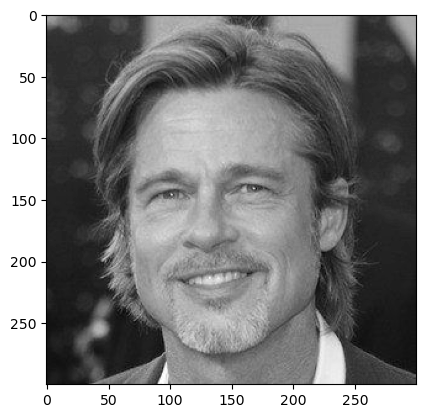

In [11]:
plt.imshow(gray, cmap='gray')

I was now ready to test the Haar Cascade Classifiers from Open CV2. 

On a very basic level, these classifiers work by looking for areas of the photograph that are lighter/darker than others. For example, the tip of a nose is lighter than its surroundings, whereas a pupil is generally darker than its surrounding eye parts. 

I'll have the Classifiers find the face and eyes, and return a cropped face. 

In [12]:
face_cascade = cv2.CascadeClassifier('/Users/anupamsivaram/Desktop/Image Classification Code/opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/Users/anupamsivaram/Desktop/Image Classification Code/opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 42,  69, 187, 187]], dtype=int32)

In [13]:
(x, y, w, h) = faces[0]
x, y, w, h

(42, 69, 187, 187)

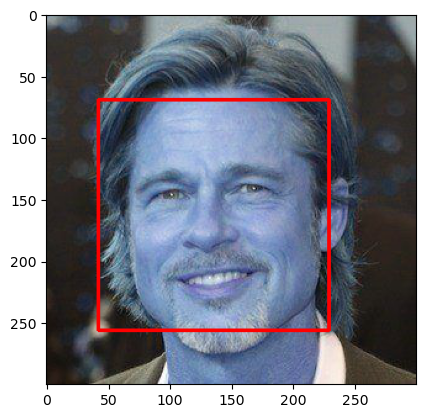

In [14]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

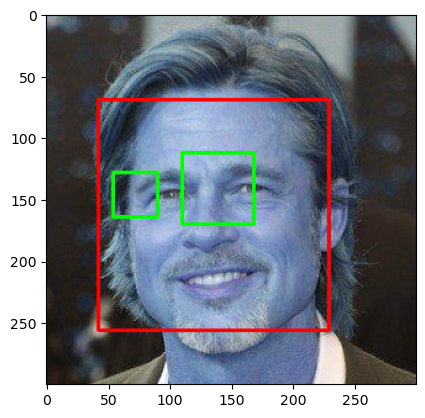

In [15]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, y:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        
plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

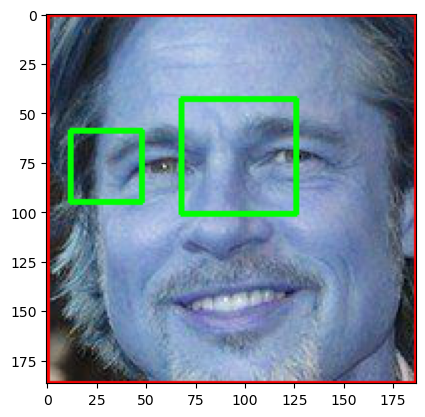

In [16]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

My classifier does a decent job with the face, but does not get the eyes exactly right. This is an indicator that alternatives (eg LBP Cascade) may be better. 

I'll create a function now that does this for all of my images, and test the function on the image that I have been working with. 

Very importantly, I want the function to only return cropped images if exactly two eyes are present. This prevents images where the face is not visible, or where there is more than one person in the picture. 

In [17]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
            print("Error reading image:")
            return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) == 0:
        print(f"No faces detected in image")
        return None
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) == 2:
            return roi_color     

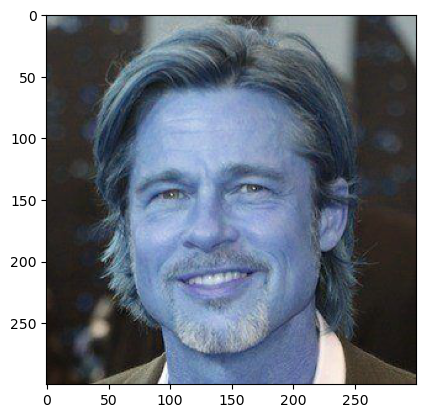

In [18]:
original_image = cv2.imread('/Users/anupamsivaram/Desktop/Image Classification Code/Raw Test Images/brad pitt headshot - Google Search/brad-pitt-7.jpg')
plt.imshow(original_image)

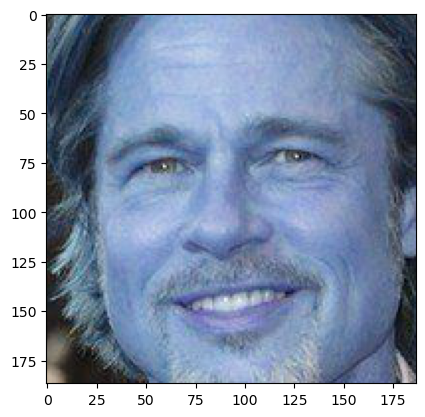

In [19]:
cropped_image = get_cropped_image_if_2_eyes('/Users/anupamsivaram/Desktop/Image Classification Code/Raw Test Images/brad pitt headshot - Google Search/brad-pitt-7.jpg')
plt.imshow(cropped_image)

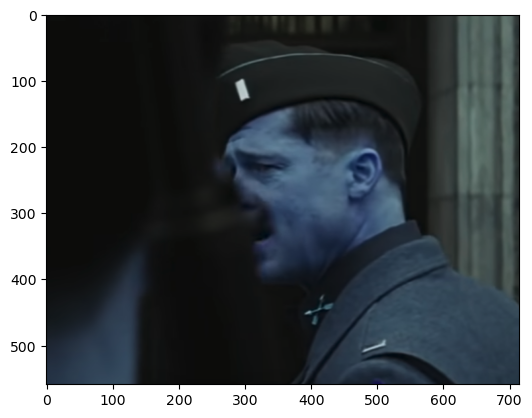

In [99]:
# Example of distorted picture. 

org_image_obstructed = cv2.imread('/Users/anupamsivaram/Desktop/Image Classification Code/brad pitt obstructed.png')
plt.imshow(org_image_obstructed)

In [151]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('/Users/anupamsivaram/Desktop/Image Classification Code/brad pitt obstructed.png')
cropped_image_no_2_eyes

No faces detected in image


In [22]:
path_to_data = '/Users/anupamsivaram/Desktop/Image Classification Code/dataset'
path_to_cr_data = '/Users/anupamsivaram/Desktop/Image Classification Code/dataset/cropped/'

In [23]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [25]:
img_dirs;

I'll now apply this function to the raw images in my local drive. Many of these images will return errors as they do not meet the 2 eyes requirement. I have suppressed the output for this reason. 

The code will make a subdrive called "Cropped", if it doesn't exist already, and sort the cropped images into this drive based on the Actor that they are (supposedly) an image of, with appropriate file names. 

In [33]:
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [90]:
with io.capture_output() as captured:

    cropped_image_dirs = []

    for img_dir in img_dirs:
        count = 1
        celebrity_name = img_dir.split('/')[-1]
        print(celebrity_name)

        celebrity_file_names_dict[celebrity_name] = []

        cropped_folder = path_to_cr_data + celebrity_name
        if not os.path.exists(cropped_folder):
            os.makedirs(cropped_folder)
            cropped_image_dirs.append(cropped_folder)
            print("Generating cropped images in folder: ", cropped_folder)


        for entry in os.scandir(img_dir):
            if entry.is_file() and entry.name.lower().endswith(('.png', '.jpg', '.jpeg')):
                roi_color = get_cropped_image_if_2_eyes(entry.path)
                if roi_color is not None:
                    cropped_file_name = celebrity_name + str(count) + ".png"
                    cropped_file_path = os.path.join(cropped_folder, cropped_file_name)
                    cv2.imwrite(cropped_file_path, roi_color)
                    count += 1
                    celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
    pass

print("Done.")

Done.


I now have a folder of Cropped faces! Unfortunately, some of these are not of the actor in question, so I had to manually edit out a few of the cropped images.

# Feature Engineering

At this stage, I'll define a function called w2d to convert the images to grayscale, convert that array data into float type, and compute the coefficients of the wavelengths. 

For Context: Just like sound, images can be interpreted in frequencies - here, wavelengths. 

This will allow reconstructions of the image in a more machine-readable way, as we see below. 

In [37]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #These are Datatype conversions. We'll convert the images to grayscale.
    imArray = cv2.cvtColor ( imArray, cv2.COLOR_RGB2GRAY )
    #Convert this data to float. 
    imArray = np.float32(imArray)
    imArray /= 255;
    # Compute the coefficients. 
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    
    #Process the coefficients. 
    coeffs_H=list(coeffs)
    coeffs_H[0] *=0;
    
    #Reconstruction.
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

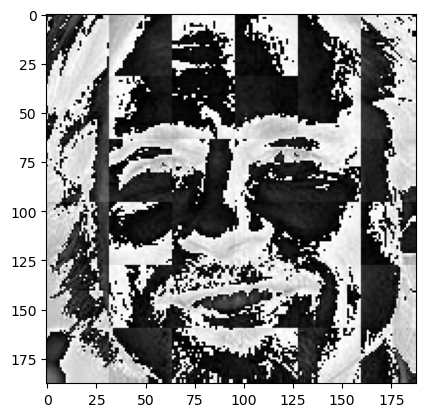

In [38]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [92]:
class_dict = {}
count = 0

for celebrity_name in celebrity_file_names_dict.keys():
    if "cropped" not in celebrity_name.lower():
        class_dict[celebrity_name] = count
        count += 1

class_dict

{'Brad Pitt': 0,
 'Leonardo Dicaprio': 1,
 'Tom Cruise': 2,
 'Dwayne Johnson': 3,
 'Will Smith': 4}

In [93]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scaled_raw_img = cv2.resize(img, (32,32))
        img_har = w2d(img,'db1',5)
        scaled_img_har = cv2.resize(img_har, (32,32))
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [94]:
len(X)

123

In [95]:
len(X[0])

4096

In [96]:
X[0]

array([[145],
       [165],
       [197],
       ...,
       [  0],
       [199],
       [  0]], dtype=uint8)

In [97]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(123, 4096)

In [98]:
X[0]

array([145., 165., 197., ...,   0., 199.,   0.])

# Model Preparation

We'll split the data for the model into both X and y. X will contain the relevant image data and y will contain the response variable.

Afterwards, we will split 80% of the data into training data, and 20% into test data.

Here, I run a Pipeline prediction model to test. 

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6

In [106]:
len(X_test)

25

In [107]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.67      0.50      0.57         4
           2       0.40      0.67      0.50         3
           3       0.69      0.90      0.78        10
           4       0.50      0.33      0.40         3

    accuracy                           0.60        25
   macro avg       0.55      0.52      0.51        25
weighted avg       0.59      0.60      0.57        25



In [108]:
len(y_test)

25

# Model Building and Tuning

In [109]:
model_params = {
    # SVM
    'svm': {
        'model': SVC(gamma='auto', probability=True),
        'params': {
            'svc__C': [1, 10, 100, 1000],
            'svc__kernel': ['rbf', 'linear']
        }
    },
    # Random Forest
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [1, 5, 10]
        }
    },
    # Logistic Regression
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'logisticregression__C': [1, 5, 10]
        }
    },
    # Naive Bayes
    'naive_bayes': {
        'model': GaussianNB(),
        'params': {}
    },
    # Decision Tree
    'decision_tree': {
        'model': tree.DecisionTreeClassifier(random_state=1),
        'params': {
            'decisiontreeclassifier__max_depth': [None, 5, 10]
        }
    },
    # K-Nearest Neighbors
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'kneighborsclassifier__n_neighbors': [3, 5, 7],
            'kneighborsclassifier__weights': ['uniform', 'distance']
        }
    },
    # XGBoost
    'xgboost': {
        'model': XGBClassifier(),
        'params': {
            'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
            'xgbclassifier__n_estimators': [50, 100, 200]
        }
    }
}

In [111]:
y_train = np.array(y_train)

print(y_train.shape)

(98,)


In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import pandas as pd

model_params = {
    'svm': {
        'model': SVC(gamma='auto', probability=True),
        'params': {
            'svc__C': [1, 10, 100, 1000],
            'svc__kernel': ['rbf', 'linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [1, 5, 10]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'logisticregression__C': [1, 5, 10]
        }
    },
    'naive_bayes': {
        'model': GaussianNB(),
        'params': {}
    },
    'decision_tree': {
        'model': tree.DecisionTreeClassifier(random_state=1),
        'params': {
            'decisiontreeclassifier__max_depth': [None, 5, 10]
        }
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'kneighborsclassifier__n_neighbors': [3, 5, 7],
            'kneighborsclassifier__weights': ['uniform', 'distance']
        }
    },
    'xgboost': {
        'model': XGBClassifier(),
        'params': {
            'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
            'xgbclassifier__n_estimators': [50, 100, 200]
        }
    }
}

scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)  # Subtracting 1 to make class labels start from 0
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,svm,0.631053,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.448421,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.532105,{'logisticregression__C': 5}
3,naive_bayes,0.418947,{}
4,decision_tree,0.428421,{'decisiontreeclassifier__max_depth': None}
5,knn,0.500526,"{'kneighborsclassifier__n_neighbors': 5, 'knei..."
6,xgboost,0.428421,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas..."


In [113]:
best_estimators['svm'].score(X_test, y_test)

0.52

In [114]:
best_estimators['random_forest'].score(X_test, y_test)

0.4

In [115]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.56

**Comments:**

Although none of the models performed ideally, the SVM model ensured the best prediction score, with 63% on the training data when hypertuned and 52% on the test data. 

Using the Confusion Matrix from Sklearn.metrics, and Seaborn to visualize it, I was able to assess what may have gone wrong with the image classification. 

I also saved the model and dictionary for future use. 

In [117]:
best_clf = best_estimators['svm']

In [123]:
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[1, 0, 1, 2, 1],
       [2, 2, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [3, 0, 0, 7, 0],
       [0, 0, 0, 1, 2]])

Text(95.72222222222221, 0.5, 'Truth')

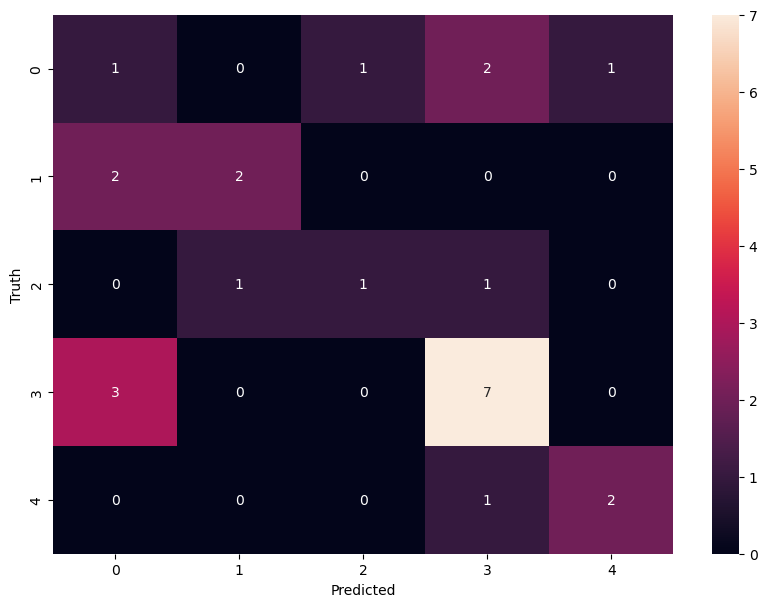

In [119]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [120]:
class_dict

{'Brad Pitt': 0,
 'Leonardo Dicaprio': 1,
 'Tom Cruise': 2,
 'Dwayne Johnson': 3,
 'Will Smith': 4}

In [245]:
!pip install joblib
import joblib
# We'll save the model as a pickle in a file.
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [239]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))
print("Done")

Done


# Key Takeaways

**My initial hypothesis was proven to be incorrect** the Haar Cascade method within OpenCV2 would be sufficient to predict the identity of a Hollywood actor, given an image with a full visible face.

The questions asked in the beginning of the project are answered below:

1. **Can this goal be achieved with the use of simple object detection methods like Haar Cascade, without more sophisticated methods like CNNs?**

    I believe that my image analysis would have benefitted from different methods, such as CNNs or LBP Cascades. As observed in the eye detection of Brad Pitt, the Haar Cascade method can sometimes misidentify parts of the image, using its light-dark logic, and may be suboptimal for analyses like these. 
    Of course, the analysis would most likely have benefitted from a larger sample size of images to train with, which Amazon Prime has ample access to. 
    I also believe that the SVM model here would also perform optimally compared to other models. Given its ability to deal with non-linear and complex decision boundaries between classes, it was a clear winner compared to other models that may not be as good at image regression. Another strong contender is Logistic Regression. 

2. **What factors may confuse the image classification model?**

    The Confusion Matrix generated at the end of the project yields some interesting results. As all images were converted to grayscale, then frequency matrices, the model cannot rely on race to make its determinations. Within the test data, my model was the most accurate when given pictures of Dwayne Johnson, as opposed to other actors. I suspect that this is because Dwayne Johnson's appearance (bald with a shaved face) has remained consistent over his Hollywood career. This consistency cannot be found for other actors assessed in this model: Brad Pitt is the most pertinent example of an actor changing hair length, hair style, and facial hair frequently. Accordingly, the model had the most errors when predicting a person may be him, or predicting that a picture of him was someone else.
    This leads me to believe that when building a model like this, extra attention must be placed on the changing nature of facial hair, hair length, and hair style. This was surprising to me, as the Cascade method focused on face and eye locations, but the changing nature of these aspects may distort its capture of the face. 

3. **How can the model be made more accurate?**

    Addressed briefly in (1) and (2), a second iteration of this model would employ a larger sample size, higher quality pictures, alternative methods to Haar Cascade that specialize in face detection, and would ensure that the training sample for a person whose appearance changes frequently consisted of large subsamples of each of these periods in their life. 

4. **Outside of the data analysis, given that Prime's X-Ray feature is over 10 years old, why might competitors abstain from replicating the feature?**

    This study has exposed several considerations that would need to be addressed when building an "X-Ray" feature. Amazon Prime has done a good job with its execution, as I have never caught the X-Ray omitting an actor from a scene; however, the amount of work required to execute this feature well may not be worth it to Prime's competitors, who may concentrate on alternative product features for subscriber acquisition and retention. It is also possible that "X-Ray" is a product differentiator that does not actually bring in or maintain subscribers, but merely functions to differentiate Amazon Prime's largely homogeneous services from those of its competitors. 